# Simple Reinforcement Learning with Tensorflow: Part 3 - Model-Based RL

In this iPython notebook we implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem using pyTorch. Original series with tensorflow implementation can be found on [Medium](https://medium.com/p/9a6fe0cce99).

In [125]:
%matplotlib inline

import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

xrange = range

In [191]:
class PolicyNet(torch.nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(4, 8)
        self.fc2 = torch.nn.Linear(8, 2)
        self.relu = torch.nn.ReLU()
        self.sigm = torch.nn.Softmax()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigm(out)
        return out


class ModelNet(torch.nn.Module):
    """
    Input: (state, action) [5 x 1]
    Output: (next state) [4 x 1]
    """
    def __init__(self):
        super(ModelNet, self).__init__()
        self.fc1 = torch.nn.Linear(5, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc_state = torch.nn.Linear(256, 4)
        self.fc_reward = torch.nn.Linear(256, 1)
        self.fc_done = torch.nn.Linear(256, 1)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        state = self.fc_state(out)
        return state


class create_model_env():
    """
    Simulated enviroment based on model.
    """
    def __init__(self, model, state=None):
        self.model = model
        self.state = self.reset() if state is None else state
        self.n = 0
    def update(self, model):
        self.model = model
    def step(self, action):
        """
        Predicts next state based on current state and action taken.
        
        Returns done status if:
            * Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
            * Pole Angle is more than ±12°
            * Episode length is greater than 200
        """
        state = model.forward(torch.tensor(np.hstack([self.state, action]), dtype=torch.float))
        state = state.detach().numpy()
        self.n += 1
        self.state = state
        # Episode termination
        done = (abs(state[0]) > 2.4) or (abs(state[2]) > 12 * 2 * np.math.pi / 360) or (self.n == 200)
        return state, 1.0, done, {}
    def reset(self):
        # Generate reasonable starting point
        self.state = np.random.uniform(-0.05, 0.05, [4])
        self.n = 0
        return self.state


def discount_rewards(r, gamma=0.99):
    """
    Take 1D float array of rewards and compute discounted reward .
    For example: 0, 1, 2, 3, 4 will be trasnformed to 9.7, 9.8, 8.9, 6.96, 4
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


# Initiate networks
policy_loss = []
model_loss = []
model = ModelNet()
model_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
policy = PolicyNet()
policy_adam = torch.optim.Adam(policy.parameters(), lr=1e-3)

real_env_episodes = 0
model_env_episodes = 0

In [199]:
drawFromModel = True     # When set to True, will use model for observations
trainTheModel = False     # Whether to train the model
trainThePolicy = True    # Whether to train the policy

total_episodes = 1000 # Set total number of episodes to train agent on.
max_ep = 1000

total_reward = []

# Initiate enviroment
env = create_model_env(model) if drawFromModel else gym.make('CartPole-v0')

for i in range(total_episodes):
    if drawFromModel:
        model_env_episodes += 1
    else:
        real_env_episodes += 1
    
    state = env.reset()
    running_reward = 0
    state_history = []
    action_history = []
    reward_history = []

    for j in range(max_ep):
        if j == 999:
            print('Max episodes reached')

        action_prob = policy.forward(torch.tensor(state, dtype=torch.float))
        action = np.random.choice([0, 1], p=action_prob.detach().numpy())

        state_history.append(state)
        action_history.append(action)
        state, reward, done, info = env.step(action)
        reward_history.append(reward)
        running_reward += reward

        if done:
            total_reward.append(running_reward)

            if trainThePolicy:

                discounted_rewards = torch.tensor(discount_rewards(np.array(reward_history)), dtype=torch.float)
                action_prob = policy.forward(torch.tensor(np.stack(state_history), dtype=torch.float))
                loss = -torch.mean(torch.log(action_prob[np.arange(j+1), action_history]) * discounted_rewards)
                policy_loss.append(loss)

                policy_adam.zero_grad()
                loss.backward()
                policy_adam.step()

            if trainTheModel:

                in_state_action = np.hstack([np.array(state_history), np.array(action_history)[:, np.newaxis]])[:-1]
                out_state = model.forward(torch.tensor(in_state_action, dtype=torch.float))
                exp_state = torch.tensor(np.array(state_history)[1:], dtype=torch.float)

                loss = torch.mean((exp_state - out_state)**2)
                model_loss.append(loss)

                model_adam.zero_grad()
                loss.backward()
                model_adam.step()

            env.reset()
            break

    if i % 100 == 0:
        print(i, np.mean(total_reward[-100:]))

print('Real world episodes: {0}, Model episodes: {1}'.format(real_env_episodes, model_env_episodes))

/home/trokas/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


0 134.0
100 167.76
200 190.85
300 190.06
400 194.86
500 189.66
600 195.81
700 196.81
800 196.14
900 199.0
Real world episodes: 3000, Model episodes: 5000


## Evaluate environment model performance

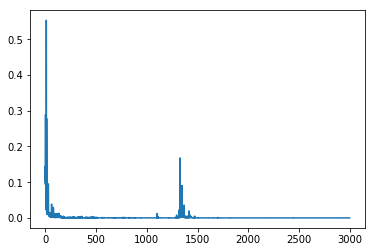

In [200]:
plt.plot(model_loss)

**Benchmark:** with 3000 real world episodes Vanilla-Policy manages to reach score ~180 out of last 100 episodes.

**Result:** with 3000 real world episodes and 5000 model interactions we have much more robust model which manages to win 100 last games with score 200! 